In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re, os, math, random
from collections import Counter
from collections import defaultdict
import operator
from tqdm import tqdm
import jieba
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from nltk.stem import SnowballStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Bidirectional, CuDNNGRU, CuDNNLSTM, Conv1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops
import gc

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [56]:
jieba.enable_parallel(8)
train_corpus = "train_first.csv"
test_corpus = "predict_first.csv"
vocab_path = "Chinese_corpus_dict.vocab"
clean_stop_word = False
vocab_size = 20000
embedding_dims = 300
seq_length = 100
pointer = 0

#####################
## Text RNN
rnn_recurrent_units = 48
rnn_dense_units = 32
rnn_output_units = 5
rnn_batch_size = 256
#####################

#####################
## Text CNN
cnn_filter_nums = 120
cnn_dense_units = 72
cnn_output_units = 5
cnn_batch_size = 256
#####################

#####################
## Hybrid Text NN
hy_recurrent_units = 48
hy_filter_nums = 64
hy_output_units = 5
hy_batch_size = 256
#####################

#####################
## Seq2seq
seq_batch_size = 64
enc_hidden_size = 150
dec_hidden_size = 300
seq_learning_rate = 0.01
start_word = 2    # token number of <SOS>
train_epochs = 10
dropout_keep_prob = 0.75
l2_reg_lambda = 0.2
seq_label_size = 5
#####################

Process ForkPoolWorker-22:
Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Process ForkPoolWorker-23:
Process ForkPoolWorker-18:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in 

# Data Analysis

In [3]:
train_df = pd.read_csv(train_corpus)
test_df = pd.read_csv(test_corpus)

train_df.sample(100)

,Id,Discuss,Score
752,9125436c-c566-34c6-855b-05451025a701,包括神农顶景区：140.00元、官门山景区：120.00元、神农坛景区：60.00元、天燕景...,4
41503,2e34ad3a-e09f-3e3e-8479-8f75c204701e,很有趣的旅行,5
90315,fdd0f854-3eb9-3512-bcb4-8ab16add99ba,江南园林都差不多，没看过的一定要去看看，很精致，看过其他园林的话可以略过,4
55665,29cc05e6-5762-3b11-89a8-b8923d812748,印象深刻,5
92651,2129ce8e-2ac1-3f2d-a207-e2012abfef67,三颗巨大的树木，不要以为你看到过多么大的树，当你看到的时候真的会大吃一惊,3
51835,64d3ac9b-ccf7-36f6-a1af-fae5dcaf2e4e,充满商业气息，人多，满街的万三蹄。,4
44176,b2500fbc-d2dc-3c5b-ae92-41b606f63f6b,慕田峪长城历史悠久，文化灿烂，距北京城73公里，是北京著名长城景点之一，是明朝万里长城的精华...,4
59049,f2bf6bdc-6479-3fd2-927c-7b1201ff9968,价格比窗口便宜，购买也很方便，进园前购买，立刻就能取票，很不错,5
20722,d40dc923-7d2b-3d77-8266-8387471e02cd,杭州 一座我特别喜欢的城市！在如此喧嚣的大都市里，周围都是高楼大厦商场间，还有这么一片清澈的...,5
88432,167a9ef0-a2e0-3d74-8361-cbb99aac5c99,黄龙寺是明朝万历年间所建，之前看到有攻略说大殿后面是老寺，里面地面上有个龙头，据说可以准确预...,4


In [4]:
label_cols = pd.unique(train_df['Score'])
print(label_cols)

[5 4 3 2 1]


In [5]:
train_df.describe()

,Score
count,100000.000000
mean,4.470010
std,0.752134
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
test_df.head()

,Id,Discuss
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味 很喜欢这样有文化的地方
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈～
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间


In [7]:
# Data length
print("Total rows in train_corpus is {}".format(len(train_df)))
print("Total rows in test_corpus is {}".format(len(test_df)))
print(train_df['Score'].value_counts())

Total rows in train_corpus is 100000
Total rows in test_corpus is 30000
5    60097
4    28954
3     9389
2      973
1      587
Name: Score, dtype: int64


In [8]:
# Sentence length analysis
train_df['Word_Length'] = train_df['Discuss'].apply(lambda x: len(str(x)))
train_df

,Id,Discuss,Score,Word_Length
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,37
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,31
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,35
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,61
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,6
5,3b7f3f2e-886f-3a68-a810-2c37cfd728d3,方便,4,2
6,88914409-bd13-3d47-b5a2-691177dde8fd,看水看山都可以。感受古人的智慧结晶，秋景美丽如画，红黄绿相间！对于身体状况不佳的人来说，走平...,4,55
7,bf13ec92-6079-3451-ade3-88020cb0dcb5,赞,5,1
8,489c3d94-9c44-3cf2-949c-1b507c374c69,唯一糟点,5,4
9,285bba78-16a3-3c1d-b648-baa483883ee3,周未周边游,5,5


In [9]:
# print(train_df['Word_Length'].value_counts().head())

# For test_data
test_df['Word_Length'] = test_df['Discuss'].apply(lambda x: len(str(x)))
# print(test_df['Word_Length'].value_counts().head())
print(train_df['Word_Length'].describe(), "\n", test_df['Word_Length'].describe())

count    100000.000000
mean         48.283500
std          78.522278
min           1.000000
25%           9.000000
50%          24.000000
75%          52.000000
max        1336.000000
Name: Word_Length, dtype: float64 
 count    30000.000000
mean        49.249733
std         77.584046
min          1.000000
25%         11.000000
50%         25.000000
75%         54.000000
max       1136.000000
Name: Word_Length, dtype: float64


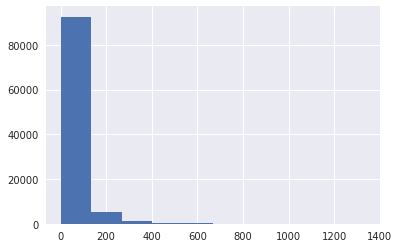

In [10]:
# histogram graph
sns.set()
train_df['Word_Length'].hist()
plt.show()

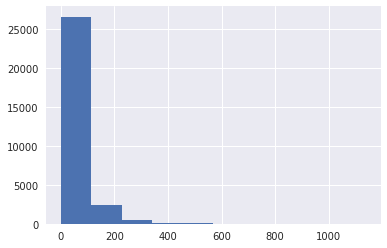

In [11]:
plt.figure()
plt.hist(test_df['Word_Length'])
plt.show()

In [12]:
train_df.sort_values('Word_Length', ascending=False).head(100)['Score'].value_counts()

5    56
4    31
3    12
1     1
Name: Score, dtype: int64

In [13]:
# transform to one-hot
Score = train_df['Score']
data = pd.get_dummies(Score)
train_df = pd.concat([train_df, data], axis=1)
train_df.head()

,Id,Discuss,Score,Word_Length,1,2,3,4,5
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,37,0,0,0,0,1
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,31,0,0,0,1,0
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,35,0,0,0,1,0
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,61,0,0,0,0,1
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,6,0,0,0,0,1


## Get positive labels

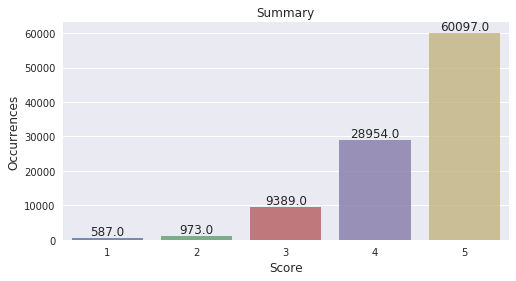

In [14]:
x = train_df.iloc[:, 4:].sum()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Summary")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Score', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, ha='center', va='bottom', s='{:.1f}'.format(abs(label)))
    
plt.show()

## Correlations of labels

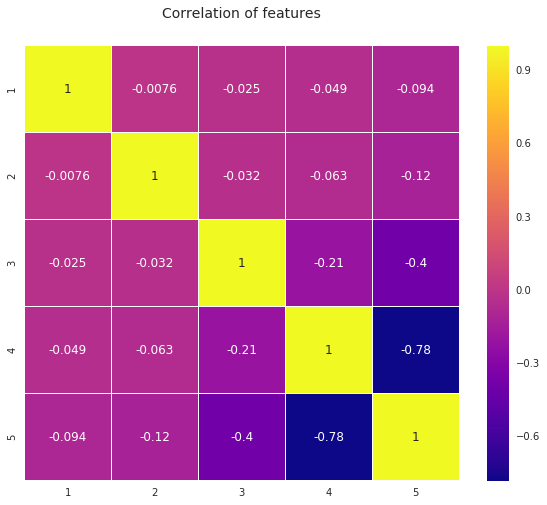

In [15]:
# No sentences contains up to 2 Score-labels
colormap = plt.cm.plasma
plt.figure(figsize=(10, 8))
plt.title('Correlation of features', y=1.05, size=14)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Processing

In [16]:
def clean_text(text, stem_words=False):
    text = re.sub(r',', '，', text)
    text = re.sub(r'\.+', '...', text)
    text = re.sub(r'\.{6}', '...', text)
    text = re.sub(r'…', '...', text)
    text = re.sub(r';', '；', text)
    text = re.sub(r'°', '。', text)
    text = re.sub(r'】', ']', text)
    text = re.sub(r'【', '[', text)
    text = re.sub(r'\)', '\）', text)
    text = re.sub(r'\(', '\（', text)
    text = re.sub(r'“', '"', text)
    text = re.sub(r' ', '', text)
    text = re.sub(r'”', '"', text)
    text = re.sub(r'～', '~', text)
    text = re.sub(r'·', '。', text)
    text = re.sub(r'!', '！', text)
    text = re.sub(r'—', '-', text)
    text = re.sub(r'》', '\）', text)
    text = re.sub(r'《', '\（', text)
    text = re.sub(r'\?', '\？', text)
    text = re.sub(r'。。。', '...', text)
    text = re.sub(r'。。。。。。', '...', text)
    text = re.sub(r':', '：', text)
    
#     # for English_sentence
#     text = replace_numbers.sub('', text)
#     text = special_character_removal.sub('', text)
#     if stem_words:
#         text = text.split()
#         stemmer = SnowballStemmer('english')
#         stemmed_words = [stemmer.stem(word) for word in text]
#         text = " ".join(stemmed_words)
    
    return text

# regex to remove all Non-Alpha Numeric and space
special_character_removal = re.compile(r'[^a-z\d ]', re.IGNORECASE)

# regex to remove all Alpha Numeric and space
special_alpha_removal = re.compile(r'[a-z\d ]', re.IGNORECASE)

# regex to replace all numeric
replace_numbers = re.compile(r'\d+', re.IGNORECASE)

In [17]:
# Check NaN
print(np.any(train_df.isnull()) == True, np.any(test_df.isnull()) == True)

False False


In [18]:
# Regular dictionary
print("MSG : Processing text datasets...")
cols_target = [1, 2, 3, 4, 5]

list_sentence_train = train_df['Discuss'].fillna("no discuss").values
train_discusses = [clean_text(text) for text in list_sentence_train]
train_df['Discuss'] = pd.Series(train_discusses).astype(str)

list_sentence_test = test_df['Discuss'].fillna("no discuss").values
test_discusses = [clean_text(text) for text in list_sentence_test]
test_df['Discuss'] = pd.Series(test_discusses).astype(str)

# cleaned_train_discuss = []
# for i in range(len(train_df)):
#     cleaned_discuss = clean_text(train_df['Discuss'][i])
#     cleaned_train_discuss.append(cleaned_discuss)
# train_df['Discuss'] = pd.Series(cleaned_train_discuss).astype(str)

# cleaned_test_discuss = []
# for i in range(len(test_df)):
#     cleaned_discuss = clean_text(test_df['Discuss'][i])
#     cleaned_test_discuss.append(cleaned_discuss)
# test_df['Discuss'] = pd.Series(cleaned_test_discuss).astype(str)
# test_df.head()

MSG : Processing text datasets...


In [19]:
# Clean up the sentence text & Word segmentation analysis
word_dict = defaultdict(int)

for sentence in tqdm(train_df['Discuss']):
    seg_list = jieba.cut(sentence, cut_all=False)
    for word in seg_list:
        word_dict[word] += 1
word_dict = sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True)
word_dict
print(len(word_dict))

100%|██████████| 100000/100000 [00:44<00:00, 2238.19it/s]

88384


## A quick view of vocabulary

In [20]:
chinese_list, sign_list, dig_english_list = [], [], []
for word, count in word_dict:
    for char in word:
        if char >= u'\u4E00' and char <= u"\u9FA5":
            chinese_list.append((word, count))
        elif (char >= u'\u0041' and char <= u'\u005A') or (char >= u'\u0061' and char <= u'\u007A') or (char >= u'\u0030' and char <= u'\u0039'):
            dig_english_list.append((word, count))
            break
        else:
            sign_list.append((word, count))
            break
sorted_dig_english_list = sorted(set(dig_english_list), key=lambda x: x[1], reverse=True)
sorted_sign_list = sorted(set(sign_list), key=lambda x: x[1], reverse=True)
sorted_chinese_list = sorted(set(chinese_list), key=lambda x: x[1], reverse=True)
print("chinese_word: ", len(sorted_chinese_list))
print("dig_english_word: ", len(sorted_dig_english_list))
print("sign_count: ", len(sorted_sign_list))
print(sorted_chinese_list[:10000], '\n\n', sorted_dig_english_list[:50], '\n\n', sorted_sign_list[:20])

chinese_word:  84768
dig_english_word:  3046
sign_count:  573
[('的', 161679), ('了', 43115), ('是', 42184), ('很', 30622), ('去', 26710), ('在', 24941), ('有', 22118), ('也', 17749), ('都', 16584), ('好', 14719), ('就', 14467), ('可以', 14124), ('不错', 13325), ('我', 12365), ('人', 11654), ('和', 11515), ('到', 11449), ('不', 10688), ('还', 9684), ('地方', 9463), ('景区', 9329), ('一个', 9325), ('就是', 8760), ('还是', 8362), ('非常', 8061), ('看', 8018), ('没有', 7675), ('要', 7669), ('很多', 7623), ('值得', 7557), ('上', 7371), ('这里', 7065), ('我们', 7010), ('景点', 6773), ('多', 6622), ('感觉', 6577), ('风景', 6565), ('来', 6194), ('时候', 5980), ('走', 5976), ('比较', 5561), ('但是', 5535), ('美', 5115), ('里面', 5058), ('景色', 4974), ('门票', 4828), ('真的', 4819), ('着', 4802), ('大', 4663), ('吧', 4586), ('看到', 4526), ('会', 4494), ('还有', 4459), ('从', 4360), ('你', 4327), ('说', 4176), ('没', 4144), ('元', 4034), ('不过', 3955), ('玩', 3924), ('北京', 3900), ('时间', 3888), ('但', 3805), ('特别', 3765), ('西湖', 3677), ('最', 3656), ('中', 3656), ('这', 3601), ('个'

In [21]:
# create stop words
chinese_stop_words = [word[0] for word in sorted_chinese_list[vocab_size - 24:]]
english_stop_words = [word[0] for word in sorted_dig_english_list]
sign_stop_words = [word[0] for word in sorted_sign_list[20:]]
stop_words = chinese_stop_words + english_stop_words + sign_stop_words
print(len(stop_words))

68391


In [22]:
train_df = train_df.drop('Word_Length', axis=1)
train_df

,Id,Discuss,Score,1,2,3,4,5
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,0,0,0,0,1
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,0,0,0,1,0
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,0,0,0,1,0
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,0,0,0,0,1
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,0,0,0,0,1
5,3b7f3f2e-886f-3a68-a810-2c37cfd728d3,方便,4,0,0,0,1,0
6,88914409-bd13-3d47-b5a2-691177dde8fd,看水看山都可以。感受古人的智慧结晶，秋景美丽如画，红黄绿相间！对于身体状况不佳的人来说，走平...,4,0,0,0,1,0
7,bf13ec92-6079-3451-ade3-88020cb0dcb5,赞,5,0,0,0,0,1
8,489c3d94-9c44-3cf2-949c-1b507c374c69,唯一糟点,5,0,0,0,0,1
9,285bba78-16a3-3c1d-b648-baa483883ee3,周未周边游,5,0,0,0,0,1


In [23]:
train_data = train_df.Discuss.values
train_label = train_df['Score'].values
test_data = test_df.Discuss.values
print(train_data.shape, test_data.shape, train_label.shape)

(100000,) (30000,) (100000,)


# Data helper

## Build own vocab & data loader

In [24]:
def build_vocab(vocab_path, data):
    files = open(vocab_path, 'w', encoding='utf-8')
    files.write("{}\t1000000000\n{}\t1000000000\n{}\t1000000000\n{}\t1000000000\n".format("<PAD>", "<UNK>", "<SOS>", "<EOS>"))
    for word, count in data:
        files.write("{}\t{}\n".format(word, count))
        
def mini_batch(vocab_path, data, padding):
    token_seqs, sentences = load_datasets(vocab_path, data, padding)
    num_batch = int(len(sentences) / seq_batch_size)
    token_seqs = token_seqs[:num_batch * seq_batch_size]
    sentences = sentences[:num_batch * seq_batch_size]
    token_batch = np.split(np.array(token_seqs), num_batch, 0)
    sentence_batch = np.split(np.array(sentences), num_batch, 0)
    return token_batch, sentence_batch, num_batch
    
def load_datasets(vocab_path, data, padding=False):
    sentences = [line for line in data if line]
    word2idx, idx2word = load_vocab(vocab_path)
    
    token_list, sources = [], []
    for source in sentences:
        temp_seg = jieba.cut(source, cut_all=False)
        seg_list = [i for i in temp_seg]
        x = [word2idx.get(word, 1) for word in (" ".join(str(i) for i in seg_list) + ' <EOS>').split()]
        if padding:
            if len(x) < seq_length:
                x += [0 for _ in range(seq_length - len(x))]
            else:
                x = x[:100]
        token_list.append(x)
        sources.append(source)
    return token_list, sources
    
def load_vocab(vocab_path):
    vocab = [line.split()[0] for line in open(vocab_path, 'r', encoding='utf-8').read().splitlines()]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {word2idx[word]: word for word in word2idx}
    return word2idx, idx2word
    
def next_batch(token_batches, sentence_batches, pointer, num_batch):
    result = token_batches[pointer]
    sentence = sentence_batches[pointer]
    pointer = (pointer + 1) % num_batch
    return result, sentence

### Tokenizer

In [25]:
# Load Dataset
data_series = sorted(sorted_chinese_list[:9976] + sorted_sign_list[:20], key=lambda x: x[1], reverse=True)
build_vocab(vocab_path, data_series)
print("MSG : Finished building vocab file.")

# data tokenize & loaded by mini_batch
token_sequences, sentences, num_batch = mini_batch(vocab_path, train_data, True)
unpad_token_sequences, unpad_sentences, _ = mini_batch(vocab_path, train_data, False)
print("MSG : Finished initialize batch datasets.")

MSG : Finished building vocab file.
MSG : Finished initialize batch datasets.


In [26]:
word2idx, idx2word = load_vocab(vocab_path)
sample_indice = random.randint(0, num_batch)

In [27]:
print("training set without padded index format: ")
print(unpad_token_sequences[sample_indice][:3], '\n batch_size is: ', len(unpad_token_sequences[sample_indice]))

training set without padded index format: 
[list([1405, 5, 1, 4, 27, 3416, 10, 7, 612, 6, 152, 52, 5, 1502, 1162, 12, 235, 125, 4, 55, 175, 470, 1710, 7, 692, 4072, 7, 6, 152, 8, 33, 9, 122, 1, 106, 966, 10, 5, 31, 4, 566, 5, 640, 16, 9, 1671, 4, 430, 7, 518, 1967, 8307, 5, 779, 6, 566, 5, 5068, 246, 81, 58, 4, 1511, 27, 2246, 16, 20, 6, 59, 5, 2064, 4562, 4, 3378, 2051, 5, 396, 4, 12, 361, 1967, 5, 1042, 6, 1475, 9, 302, 4, 204, 1710, 538, 10, 66, 6, 3])
 list([1114, 66, 3])
 list([2118, 2440, 75, 11, 549, 462, 1, 21, 1, 21, 1, 21, 1, 21, 1, 21, 1, 21, 1, 1800, 225, 319, 1, 272, 6, 25, 1, 21, 24, 1, 2390, 75, 2134, 1, 74, 4, 6265, 1, 225, 628, 693, 6, 25, 1, 21, 24, 1, 1, 79, 75, 674, 1, 75, 1, 613, 1, 75, 1, 6, 25, 1, 21, 24, 1, 259, 79, 75, 1, 388, 6, 25, 1, 21, 24, 1, 281, 335, 75, 2734, 1, 246, 4, 253, 480, 1389, 5, 1010, 2161, 4, 1, 3225, 982, 4, 4007, 936, 5780, 4, 253, 1, 5, 2590, 1, 7, 1, 64, 23, 2734, 1, 4, 1, 1, 4, 1, 1690, 64, 23, 3139, 5, 1, 4, 163, 2131, 1, 5, 1, 1, 13, 1

In [28]:
print("training set with padded(by zero) index format: ")
print(token_sequences[sample_indice][:3], '\n batch_size is: ', len(token_sequences[sample_indice][1]))
tokens = token_sequences[sample_indice][:3]

training set with padded(by zero) index format: 
[[1405    5    1    4   27 3416   10    7  612    6  152   52    5 1502
  1162   12  235  125    4   55  175  470 1710    7  692 4072    7    6
   152    8   33    9  122    1  106  966   10    5   31    4  566    5
   640   16    9 1671    4  430    7  518 1967 8307    5  779    6  566
     5 5068  246   81   58    4 1511   27 2246   16   20    6   59    5
  2064 4562    4 3378 2051    5  396    4   12  361 1967    5 1042    6
  1475    9  302    4  204 1710  538   10   66    6    3    0    0    0
     0    0]
 [1114   66    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

In [29]:
print("training set with padded(by <PAD>) word format: ")
print(sentences[sample_indice][:3], '\n batch_size is: ', len(sentences[sample_indice]))
print("trainslated by tokens: ", [idx2word.get(word, 1) for sent in tokens for word in sent])

training set with padded(by <PAD>) word format: 
['暑假的末尾，和闺蜜去了鼓浪屿。那时候的厦门依然有好多游客，但是已经算是避开了旺季高峰期了。那是一个很适合装逼小清新去的地方，岛上的人民都很悠闲，开了许多浪漫格调的小店。岛上的钢琴博物馆特别美，教堂和别墅都不错。里面的巷子很深，富有古典的气息，有一种浪漫的氛围。海鲜很便宜，最好避开节假日去吧。'
 '还行吧'
 '如何抵达：在市区乘坐103/50/56/5/40/81/52均可到达周王城广场。<br/>rn门票价格：成人30元，持有效证件可享受优惠。<br/>rn开馆时间：早8：30至18：30。<br/>rn参观时间：40分钟。<br/>rn个人印象：天子驾六博物馆，以其精美的文物陈列，车马坑实景展示，系国内少见，以直观的形式印证了古文献\\"天子驾六，诸侯驾四，士驾二\\"记载的正确性，对研究东周时期的乘舆制度、丧葬制度以及王城陵区的历史具有重要意义，被誉为\\"东周瑰宝，举世无双\\"。展馆并不大，门票价格略高。'] 
 batch_size is:  64
trainslated by tokens:  ['暑假', '的', '<UNK>', '，', '和', '闺蜜', '去', '了', '鼓浪屿', '。', '那', '时候', '的', '厦门', '依然', '有', '好多', '游客', '，', '但是', '已经', '算是', '避开', '了', '旺季', '高峰期', '了', '。', '那', '是', '一个', '很', '适合', '<UNK>', '小', '清新', '去', '的', '地方', '，', '岛上', '的', '人民', '都', '很', '悠闲', '，', '开', '了', '许多', '浪漫', '格调', '的', '小店', '。', '岛上', '的', '钢琴', '博物馆', '特别', '美', '，', '教堂', '和', '别墅', '都', '不错', '。', '里面', '的', '巷子', '很深', '，', '富有', '古典', '的', '气息', '，', '有', '一种', '浪漫', '的', '氛围', '。', '海鲜', '很', '便宜

## Build vocabulary by Keras tools

In [30]:
# remove alpha numeric & space
list_sentence_train = train_df['Discuss'].values
train_discusses = [special_alpha_removal.sub('', text) for text in list_sentence_train]
train_df['Discuss'] = pd.Series(train_discusses).astype(str)
train_df.head()

,Id,Discuss,Score,1,2,3,4,5
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了次，但感觉还没有玩够似的！会有第三，第四次的,5,0,0,0,0,1
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,0,0,0,1,0
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,0,0,0,1,0
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,0,0,0,0,1
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,0,0,0,0,1


In [31]:
list_sentence_test = test_df['Discuss'].values
test_discusses = [special_alpha_removal.sub('', text) for text in list_sentence_test]
test_df['Discuss'] = pd.Series(test_discusses).astype(str)
test_df.head()

,Id,Discuss,Word_Length
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅,4
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮,19
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味很喜欢这样有文化的地方,18
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈~,19
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间,32


In [32]:
train_discusses_cut, test_discusses_cut = [], []

for sentence in tqdm(train_discusses):
    seg_list = jieba.cut(sentence, cut_all=False)
    train_discusses_cut.append(" ".join(seg_list))
print("MSG : Segmentation for train_discusses is Done!")

100%|██████████| 100000/100000 [00:43<00:00, 2313.20it/s]

MSG : Segmentation for train_discusses is Done!


In [33]:
train_discusses_cut[:3]

['好大 的 一个 游乐 公园 ， 已经 去 了 次 ， 但 感觉 还 没有 玩够 似的 ！ 会 有 第三 ， 第四次 的',
 '新 中国 成立 也 是 在 这 举行 ， 对 我们 中国 人 来说 有些 重要 及 深刻 的 意义 ！',
 '庐山 瀑布 非常 有名 ， 也 有 非常 多个 瀑布 ， 只是 最 好看 的 非 三叠 泉莫属 ， 推荐 一去']

In [34]:
for sentence in tqdm(test_discusses):
    seg_list = jieba.cut(sentence, cut_all=False)
    test_discusses_cut.append(" ".join(seg_list))
print("MSG : Segmentation for test_discusses is Done!")

100%|██████████| 30000/30000 [00:13<00:00, 2264.13it/s]

MSG : Segmentation for test_discusses is Done!


In [35]:
# create a tokenizer which transform a sentence to a list of ids
tokenizer = Tokenizer(num_words=vocab_size)

# build the relation between words and ids
tokenizer.fit_on_texts(train_discusses_cut + test_discusses_cut)

# transform training/testing sentences to training/testing sequences
train_sequences = tokenizer.texts_to_sequences(train_discusses_cut)
test_sequences = tokenizer.texts_to_sequences(test_discusses_cut)

word_index = tokenizer.word_index
print("Found {} unique tokens".format(len(word_index)))
train_data_seq = pad_sequences(train_sequences, maxlen=seq_length)
print("Shape of train data tensor: {}".format(train_data_seq.shape))
print("Shape of label tensor: {}".format(train_label.shape))

test_data_seq = pad_sequences(test_sequences, maxlen=seq_length)
print("Shape of test data tensor: {}".format(test_data_seq.shape))

Found 97034 unique tokens
Shape of train data tensor: (100000, 100)
Shape of label tensor: (100000,)
Shape of test data tensor: (30000, 100)


In [36]:
print("training set with word format:")
print(train_discusses[:3])

training set with word format:
['好大的一个游乐公园，已经去了次，但感觉还没有玩够似的！会有第三，第四次的', '新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！', '庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去']


In [37]:
print("training set with index format:")
print(train_sequences[:3])

training set with index format:
[[1867, 2, 24, 1102, 111, 1, 154, 7, 4, 1471, 1, 67, 40, 23, 30, 2965, 11, 58, 9, 3539, 1, 13532, 2], [577, 90, 3849, 12, 5, 8, 76, 2005, 1, 147, 37, 90, 20, 368, 241, 460, 593, 931, 2, 693, 11], [768, 200, 31, 518, 1, 12, 9, 31, 2625, 200, 1, 189, 71, 269, 2, 1392, 2562, 1, 128, 100]]


In [38]:
print("training set with padded(by zero) index format:")
print(train_data_seq[:3])

training set with padded(by zero) index format:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0  1867     2    24  1102   111     1   154
      7     4  1471     1    67    40    23    30  2965    11    58     9
   3539     1 13532     2]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0

In [49]:
train_labels = train_df[cols_target].values
train_labels

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

# Logistic_Regression Model (sklearn version)

## Muilti-classification Model

In [42]:
def judgement_score(mod, obs, n):
    summation = 0
    for i, j in zip(mod, obs):
        summation += math.pow(j - i, 2)
    RMSE = math.sqrt(summation / n)
    return 1 / (1 + RMSE)

In [43]:
# Logistic_Regression_Binary_Relevance
logreg = LogisticRegression(C=12.0)
vect = TfidfVectorizer(max_features=200000, stop_words=None)
vect_cleaned = TfidfVectorizer(max_features=200000, stop_words=stop_words)

# 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=False)

# learn the vocabulary in the training data, then use it to create a document-term matrix
for i, (train, test) in enumerate(kfold.split(train_data, train_label)):
    if not clean_stop_word:
        dtm = vect.fit_transform(train_data)
    else:
        dtm_cleaned = vect_cleaned.fit_transform(train_data[train])
    
    # training
    print("Processing {}-fold ...".format(i + 1))
    logreg.fit(dtm[train], train_label[train])
    train_y_pred = logreg.predict(dtm[train])
    print("Training accuracy is {}".format(accuracy_score(train_label[train], train_y_pred)))
    
    # validation
    validate_y_pred = logreg.predict(dtm[test])
    print("Validating accuracy is {}".format(accuracy_score(train_label[test], validate_y_pred)))
    
    # Judgement Score
    print("Training Score is {}\n Validating Score is {}\n".format(judgement_score(train_y_pred, train_label[train], len(train)), judgement_score(validate_y_pred, train_label[test], len(test))))

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Processing 1-fold ...
Training accuracy is 0.9095424342763172
Validating accuracy is 0.6226754649070186
Training Score is 0.7050654228263077
 Validating Score is 0.5372900792901723

Processing 2-fold ...
Training accuracy is 0.90908686859708
Validating accuracy is 0.6286742651469706
Training Score is 0.7042952175685545
 Validating Score is 0.5408923422535641

Processing 3-fold ...
Training accuracy is 0.9094757661281362
Validating accuracy is 0.6281743651269746
Training Score is 0.7050258146179676
 Validating Score is 0.5390277031386611

Processing 4-fold ...
Training accuracy is 0.9094545494949944
Validating accuracy is 0.6295370462953704
Training Score is 0.7064804966501992
 Validating Score is 0.5402611041585427

Processing 5-fold ...
Training accuracy is 0.9097888888888889
Validating accuracy is 0.6296
Training Score is 0.7051403792663913
 Validating Score is 0.5407986071177378

Processing 6-fold ...
Training accuracy is 0.9092444444444444
Validating accuracy is 0.6267
Training Sco

In [44]:
# training for all corpus
train_dtm = vect.fit_transform(train_data)
train_dtm_cleaned = vect_cleaned.fit_transform(train_data)

LR_model = LogisticRegression(C=12.0)
LR_model.fit(train_dtm, train_label)
train_y_pred = LR_model.predict(train_dtm)
print("Training accuracy is {}".format(accuracy_score(train_label, train_y_pred)))

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Training accuracy is 0.90819


In [45]:
# testing
test_dtm = vect.transform(test_data)
test_dtm_cleaned = vect_cleaned.transform(test_data)

submission_binary = pd.read_csv('predict_first.csv')
test_y_pred = LR_model.predict(test_dtm)
submission_binary['label'] = test_y_pred
print([len(submission_binary[submission_binary['label'] == i]) for i in range(1, 6)])
submission_binary = submission_binary.drop('Discuss', axis=1)
submission_binary.to_csv("output/LogisticRegression/evaluation_public_tfidf_200000.csv", index=False, header=False)
print("MSG : Finished generate submission file.")

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[100, 119, 1127, 3957, 24697]
MSG : Finished generate submission file.


In [ ]:
gc.collect()

## Multi-label Model

### Binary Relevance

In [46]:
submission_binary = pd.read_csv('predict_first.csv')

model = LogisticRegression(C=12.0)
for label in cols_target:
    print("Processing {}".format(label))
    y = train_df[label]
    model.fit(train_dtm, y)
    y_pred = model.predict(train_dtm)
    print("Training accuracy is {}".format(accuracy_score(y, y_pred)))
    test_y_prob = model.predict_proba(test_dtm)[:, 1]
    submission_binary[label] = test_y_prob

Processing 1
Training accuracy is 0.99799
Processing 2
Training accuracy is 0.99658
Processing 3
Training accuracy is 0.97592
Processing 4
Training accuracy is 0.92975
Processing 5
Training accuracy is 0.91502


### Classifier Chains

In [47]:
def add_features(feature_sets, features):
    return hstack([feature_sets, csr_matrix(features).T], 'csr')

In [48]:
# training with classifier chains
submission_chains = pd.read_csv('predict_first.csv')

for label in cols_target:
    print("MSG : Processing {}...".format(label))
    y = train_df[label]
    model.fit(train_dtm, y)
    y_pred = model.predict(train_dtm)
    print("Training accuracy is {}".format(accuracy_score(y, y_pred)))
    test_y = model.predict(test_dtm)
    test_y_prob = model.predict_proba(test_dtm)[:, 1]
    submission_chains[label] = test_y_prob
    train_dtm = add_features(train_dtm, y)
    print("Shape of train_dtm is now {}".format(train_dtm.shape))
    test_dtm = add_features(test_dtm, test_y)
    print("Shape of test_dtm is now {}".format(test_dtm.shape))

MSG : Processing 1...
Training accuracy is 0.99799
Shape of train_dtm is now (100000, 200001)
Shape of test_dtm is now (30000, 200001)
MSG : Processing 2...
Training accuracy is 0.99664
Shape of train_dtm is now (100000, 200002)
Shape of test_dtm is now (30000, 200002)
MSG : Processing 3...
Training accuracy is 0.97652
Shape of train_dtm is now (100000, 200003)
Shape of test_dtm is now (30000, 200003)
MSG : Processing 4...
Training accuracy is 0.93459
Shape of train_dtm is now (100000, 200004)
Shape of test_dtm is now (30000, 200004)
MSG : Processing 5...
Training accuracy is 1.0
Shape of train_dtm is now (100000, 200005)
Shape of test_dtm is now (30000, 200005)


### Combined submission

In [49]:
submission_combined = pd.read_csv('predict_first.csv')
for label in cols_target:
    submission_combined[label] = 0.5 * (submission_chains[label] + submission_binary[label])
submission_combined.head()

,Id,Discuss,1,2,3,4,5
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅,0.002264,0.003025,0.010192,0.130039,0.933567
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮,0.001794,0.002258,0.020783,0.326940,0.829009
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味 很喜欢这样有文化的地方,0.003492,0.005390,0.068004,0.282671,0.798191
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈～,0.001246,0.003663,0.033999,0.087929,0.927930
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间,0.001813,0.002211,0.003390,0.076054,0.966621


In [50]:
submission_combined = submission_combined.drop('Discuss', axis=1)
submission_combined.head()

,Id,1,2,3,4,5
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,0.002264,0.003025,0.010192,0.130039,0.933567
1,82b450db-65c2-351c-84fb-761d76582680,0.001794,0.002258,0.020783,0.326940,0.829009
2,2eec4606-590c-3fa2-b846-7f92441c54a6,0.003492,0.005390,0.068004,0.282671,0.798191
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,0.001246,0.003663,0.033999,0.087929,0.927930
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,0.001813,0.002211,0.003390,0.076054,0.966621


In [51]:
# choose max_index
def check_argmax(table, start_col):
    values = table.values[:, start_col:]
    labels = np.argmax(values, axis=1)
    return [i + 1 for i in labels]

labels_new = check_argmax(submission_combined, 1)
scores = pd.Series(labels_new, name='Score').astype(int)
submission_combined = pd.concat([submission_combined, scores], axis=1)
print([len(submission_combined[submission_combined['Score'] == i]) for i in range(1, 6)])

[74, 84, 833, 4012, 24997]


In [52]:
submission_combined = submission_combined.drop(cols_target, axis=1)
submission_combined.head()

,Id,Score
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,5
1,82b450db-65c2-351c-84fb-761d76582680,5
2,2eec4606-590c-3fa2-b846-7f92441c54a6,5
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,5
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,5


In [53]:
if not os.path.exists('output/LogisticRegression'):
    os.mkdir('output/LogisticRegression')
submission_combined.to_csv('output/LogisticRegression/evaluation_public_tfidf_200000_multilabel.csv', index=False, header=False)

In [ ]:
gc.collect()

# Neural Networks (Keras version)

## Text RNN
![](https://i.imgur.com/a4bzHwS.png)

In [54]:
def get_text_rnn():
    input_layer = Input(shape=(seq_length,))
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    # two layers BiLSTM
    x = Bidirectional(CuDNNGRU(rnn_recurrent_units, return_sequences=True))(embedding_layer)
    x = Bidirectional(CuDNNGRU(rnn_recurrent_units, return_sequences=True))(x)
    
    x = Dense(rnn_dense_units, activation='relu')(x)
    output_layer = Dense(rnn_output_units, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Text CNN
![](https://i.imgur.com/Q7mFO4w.png)

In [55]:
def get_text_cnn():
    input_layer = Input(shape=(seq_length,), dtype='int32')
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    conv_0 = Conv1D(cnn_filter_nums, 2, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    conv_1 = Conv1D(cnn_filter_nums, 3, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    conv_2 = Conv1D(cnn_filter_nums, 4, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    
    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)
    
    flatten = concatenate([maxpool_0, maxpool_1, maxpool_2])
    h1 = Dense(units=cnn_dense_units, activation='relu')(flatten)
    output_layer = Dense(units=cnn_output_units, activation='sigmoid')(h1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Hybrid Text NN
![](https://i.imgur.com/ueVojVL.png)

In [56]:
def get_hybrid_textcnn():
    input_layer = Input(shape=(seq_length,))
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    x = Bidirectional(CuDNNLSTM(hy_recurrent_units, return_sequences=True))(embedding_layer)
    x = Conv1D(hy_filter_nums, 2, kernel_initalizer='normal', padding='valid', activation='relu')(x)
    
    max_pool = GlobalMaxPooling1D()(x)
    max_pool = Dropout(0.5)(max_pool)
    
    output_layer = Dense(hy_output_units, activation='sigmoid')(max_pool)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## 10-Fold Cross Validation

In [57]:
def _train_model_by_logloss(model, batch_size, train_x, train_y, val_x, val_y, fold_id):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = "model_ckp/Keras/KerasModel" + str(fold_id) + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
    
    # training on given fold data
    hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=50, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, model_checkpoint])
    
    # get the minimal validation log loss on this fold
    bst_val_score = min(hist.history['val_loss'])
    
    # return the model with best weight, best fold-val score
    return model, bst_val_score

def train_folds(x, y, fold_count, batch_size, get_model_func):
    fold_size = len(x) // fold_count
    models = []
    score = 0
    
    # split the whole dataset to 'fold count' fold, and train our model on each fold
    for fold_id in range(fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        
        if fold_id == fold_size - 1:
            fold_end = len(x)
            
        # Generate the train/val data for fold i
        train_x = np.concatenate([x[:fold_start], x[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])
        
        val_x = x[fold_start:fold_end]
        val_y = y[fold_start:fold_end]
        
        print("Training on fold {}".format(fold_id))
        model, bst_val_score = _train_model_by_logloss(get_model_func(), batch_size, train_x, train_y, val_x, val_y, fold_id)
        score += bst_val_score
        models.append(model)
    return models, score / fold_count

In [58]:
models, val_loss = train_folds(train_data_seq, train_labels, 10, cnn_batch_size, get_text_cnn)

Training on fold 0
Train on 90000 samples, validate on 10000 samples
Epoch 1/50
90000/90000 [==============================] - 12s 138us/step - loss: 0.3146 - acc: 0.8542 - val_loss: 0.2913 - val_acc: 0.8659
Epoch 2/50
90000/90000 [==============================] - 11s 120us/step - loss: 0.2670 - acc: 0.8801 - val_loss: 0.2922 - val_acc: 0.8619
Epoch 3/50
90000/90000 [==============================] - 11s 126us/step - loss: 0.2056 - acc: 0.9151 - val_loss: 0.3168 - val_acc: 0.8609
Epoch 4/50
90000/90000 [==============================] - 11s 124us/step - loss: 0.1314 - acc: 0.9513 - val_loss: 0.3841 - val_acc: 0.8561
Epoch 5/50
90000/90000 [==============================] - 11s 123us/step - loss: 0.0889 - acc: 0.9679 - val_loss: 0.4524 - val_acc: 0.8576
Epoch 6/50
90000/90000 [==============================] - 11s 123us/step - loss: 0.0695 - acc: 0.9753 - val_loss: 0.4892 - val_acc: 0.8550
Training on fold 1
Train on 90000 samples, validate on 10000 samples
Epoch 1/50
90000/90000 [====

In [59]:
print("Overall val-loss: {}".format(val_loss))

Overall val-loss: 0.29237253170013433


## Prediction

In [60]:
test_df.head()

,Id,Discuss,Word_Length
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅,4
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮,19
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味很喜欢这样有文化的地方,18
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈~,19
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间,32


In [61]:
print("Prediction testing results ...")
test_prediction_list = []
for fold_id, model in enumerate(models):
    test_prediction = model.predict(test_data_seq, batch_size=cnn_batch_size, verbose=1)
    test_prediction_list.append(test_prediction)

# merge each folds' predictions by averaging
test_predicts = np.zeros(test_prediction_list[0].shape)
for fold_predict in test_prediction_list:
    test_predicts += fold_predict
test_predicts /= len(test_prediction_list)

Prediction testing results ...
30000/30000 [==============================] - 1s 31us/step


In [62]:
# create the submission file
test_ids = test_df['Id'].values
test_id_col = pd.Series(test_ids, name='Id')
nn_submission = pd.DataFrame(data=test_predicts, columns=cols_target)
nn_submission = pd.concat([test_id_col, nn_submission], axis=1)
score = pd.Series(check_argmax(nn_submission, 1), name='Score')
nn_submission = nn_submission.drop(cols_target, axis=1)
nn_submission = pd.concat([nn_submission, score], axis=1)
print([len(nn_submission[nn_submission['Score'] == i]) for i in range(1, 6)])

nn_submission.to_csv('output/Keras_NN/submission.csv', index=False, header=False)
print("MSG : Done for dumpping csv files.")

[163, 176, 2549, 7530, 19582]
MSG : Done for dumpping csv files.


In [ ]:
gc.collect()

# Sequence to Sequence Model (Tensorflow Version)
![](https://i.imgur.com/vbqLMM6.png)

In [43]:
# Encoder
class Encoder(object):
    def __init__(self, vocab_size, batch_size, embed_size, hidden_size, seq_length, start_word):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.start_token = tf.constant([start_word] * self.batch_size, dtype=tf.int32)
        self.enc_params = []
        
        with tf.variable_scope('encoder'):
            self.enc_embeddings = tf.Variable(self.init_matrix([self.vocab_size, self.embed_size]))
            self.enc_params.append(self.enc_embeddings)
            self.forward_layer = self.recurrent_lstm_forward(self.enc_params)
            
        # placeholder
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.seq_length])
        
        # initialize
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.enc_embeddings, self.x), perm=[1, 0, 2])
            
        h0 = tf.zeros([self.batch_size, self.hidden_size])
        self.hidden_memory_0 = tf.stack([h0, h0])
        
        # training step
        ta_embed_x_forward = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x_forward = ta_embed_x_forward.unstack(self.processed_x)
        ta_embed_x_backward = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x_backward = ta_embed_x_backward.unstack(self.processed_x)
        
        def _recurrence_lstm_forward(i, x_t, h_tm):
            h_t = self.forward_layer(x_t, h_tm)
            x_ = ta_embed_x_forward.read(i)
            return i + 1, x_, h_t
        
        def _recurrence_lstm_backward(i, x_t, h_tm):
            h_t = self.forward_layer(x_t, h_tm)
            x_ = ta_embed_x_backward.read(i)
            return i - 1, x_, h_t
        
        _, _, hidden_memory_forward = control_flow_ops.while_loop(
            cond=lambda i, _1, _2: i < self.seq_length,
            body=_recurrence_lstm_forward,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.enc_embeddings, self.start_token), self.hidden_memory_0)
        )
        
        _, _, hidden_memory_backward = control_flow_ops.while_loop(
            cond=lambda i, _1, _2: i >= 0,
            body=_recurrence_lstm_backward,
            loop_vars=(tf.constant(self.seq_length - 1, dtype=tf.int32), tf.nn.embedding_lookup(self.enc_embeddings, self.start_token), self.hidden_memory_0)
        )
        
        hidden_forward, _ = tf.unstack(hidden_memory_forward)
        hidden_backward, _ = tf.unstack(hidden_memory_backward)
        self.hidden_state = tf.concat((hidden_forward, hidden_backward), axis=1)    # shape = [batch_size, 2 * enc_hidden_size]
            
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)
    
    def recurrent_lstm_forward(self, params):
        self.Wi = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Ui = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bi = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wf = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uf = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bf = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wo = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uo = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bo = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wc = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uc = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bc = tf.Variable(self.init_matrix([self.hidden_size]))
        
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wo, self.Uo, self.bo,
            self.Wc, self.Uc, self.bc
        ])
        
        def forward(x, hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) + tf.matmul(hidden_state, self.Ui) + self.bi
            )
            
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) + tf.matmul(hidden_state, self.Uf) + self.bf
            )
            
            o = tf.sigmoid(
                tf.matmul(x, self.Wo) + tf.matmul(hidden_state, self.Uo) + self.bo
            )
            
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) + tf.matmul(hidden_state, self.Uc) + self.bc
            )
            
            c = f * cell_state + i * c_
            current_hidden_state = tf.nn.tanh(c)
            
            return tf.stack([current_hidden_state, c])
        
        return forward

In [44]:
# Decoder
class Decoder(object):
    def __init__(self, vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate, enc_params):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embed_size = embed_size
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.seq_length =seq_length
        self.start_token = tf.constant([start_word] * self.batch_size, dtype=tf.int32)
        self.learning_rate = learning_rate
        self.dec_params = enc_params
        self.grad_clip = 5.0
        
        with tf.variable_scope('decode'):
            self.dec_embeddings = tf.Variable(self.init_matrix([self.vocab_size, self.embed_size]))
            self.dec_params.append(self.dec_embeddings)
            self.forward_layer = self.recurrent_lstm_forward(self.dec_params)
            self.linear_layer = self.recurrent_linear_forward(self.dec_params)
            
        # placeholder
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.seq_length])
        self.hidden_state = tf.placeholder(tf.float32, shape=[self.batch_size, 2 * self.enc_hidden_size])
        
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.dec_embeddings, self.x), perm=[1, 0, 2])
            
        cell_state = tf.zeros([self.batch_size, 2 * self.enc_hidden_size])
        self.hidden_memory_0 = tf.stack([self.hidden_state, cell_state])
        
        # training step
        predictions = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x = ta_embed_x.unstack(self.processed_x)
        
        def _training_recurrence(i, x_t, h_tm, predictions):
            h_t = self.forward_layer(x_t, h_tm)
            o_t = self.linear_layer(h_t)
            predictions = predictions.write(i, o_t)
            x_ = ta_embed_x.read(i)
            return i + 1, x_, h_t, predictions
        
        _, _, _, self.predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.seq_length,
            body=_training_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.dec_embeddings, self.start_token), self.hidden_memory_0, predictions)
        )
        
        self.predictions = self.predictions.stack()
        self.predictions = tf.transpose(self.predictions, perm=[1, 0, 2])
        
        self.loss = -tf.reduce_sum(
            tf.one_hot(tf.cast(tf.reshape(self.x, [-1]), tf.int32), self.vocab_size, 1.0, 0.0) * tf.log(
                tf.clip_by_value(tf.reshape(self.predictions, [-1, vocab_size]), 1e-20, 1.0)
            )
        ) / (self.seq_length * self.batch_size)
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.gradients, _ = tf.clip_by_global_norm(tf.gradients(self.loss, self.dec_params), self.grad_clip)
        self.update = self.optimizer.apply_gradients(zip(self.gradients, self.dec_params))
        
        # testing step
        output_prob_sequences = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        token_sequences = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        
        def _pred_recurrence(i, x_t, h_tm, gen_o, gen_x):
            h_t = self.forward_layer(x_t, h_tm)
            o_t = self.linear_layer(h_t)
            log_prob = tf.log(o_t)
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_ = tf.nn.embedding_lookup(self.dec_embeddings, next_token)
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.vocab_size, 1.0, 0.0), o_t), axis=1))
            gen_x = gen_x.write(i, next_token)
            return i + 1, x_, h_t, gen_o, gen_x
        
        _, _, _, self.output_prob_sequences, self.token_sequences = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.seq_length,
            body=_pred_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.dec_embeddings, self.start_token), self.hidden_memory_0, output_prob_sequences, token_sequences)
        )
        
        self.token_sequences = self.token_sequences.stack()
        self.token_sequences = tf.transpose(self.token_sequences, perm=[1, 0])
            
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)
        
    def recurrent_lstm_forward(self, params):
        self.Wi = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Ui = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bi = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wf = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uf = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bf = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wo = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uo = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bo = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wc = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uc = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bc = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wo, self.Uo, self.bo,
            self.Wc, self.Uc, self.bc
        ])
        
        def forward(x, hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) + tf.matmul(hidden_state, self.Ui) + self.bi
            )
            
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) + tf.matmul(hidden_state, self.Uf) + self.bf
            )
            
            o = tf.sigmoid(
                tf.matmul(x, self.Wo) + tf.matmul(hidden_state, self.Uo) + self.bo
            )

            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) + tf.matmul(hidden_state, self.Uc) + self.bc
            )

            c = f * cell_state + i * c_
            current_hidden_state = tf.nn.tanh(c)
            
            return tf.stack([current_hidden_state, c])
        
        return forward
    
    def recurrent_linear_forward(self, params):
        self.V = tf.Variable(self.init_matrix([self.dec_hidden_size, self.vocab_size]))
        self.c = tf.Variable(self.init_matrix([self.vocab_size]))
        
        params.extend([
            self.V, self.c
        ])
        
        def forward(hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            logits = tf.matmul(hidden_state, self.V) + self.c
            output = tf.nn.softmax(logits)
            return output
        
        return forward

In [45]:
# Seq2seq Autoencoder
class Seq2seq(object):
    def __init__(self, vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate):
        self.encoder = Encoder(vocab_size, batch_size, embed_size, enc_hidden_size, seq_length, start_word)
        self.decoder = Decoder(vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate, self.encoder.enc_params)
        
    def forward(self, sess, batch):
        hidden = sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})
        loss, _ = sess.run([self.decoder.loss, self.decoder.update], feed_dict={self.decoder.x: batch, self.decoder.hidden_state: hidden})
        return loss
    
    def pred(self, sess, batch):
        hidden = sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})
        pred = sess.run(self.decoder.token_sequences, feed_dict={self.decoder.x: batch, self.decoder.hidden_state: hidden})
        return pred
    
    def convert_to_vector(self, sess, batch):
        return sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})

In [46]:
# create model
seq2seq_model = Seq2seq(vocab_size, seq_batch_size, embedding_dims, enc_hidden_size, dec_hidden_size, seq_length, start_word, seq_learning_rate)

Tensor("concat_1:0", shape=(64, 300), dtype=float32)


In [71]:
# DNN classification
class DNN_Classifier(object):
    def __init__(self, enc_hidden_size, batch_size, label_size, learning_rate, dropout_keep_prob, l2_reg_lambda):
        self.enc_hidden_size = enc_hidden_size
        self.batch_size = batch_size
        self.label_size = label_size
        self.learning_rate = learning_rate
        self.dropout_keep_prob = dropout_keep_prob
        self.l2_reg_lambda = l2_reg_lambda
            
        # placeholder
        self.x = tf.placeholder(tf.float32, shape=[self.batch_size, 2 * self.enc_hidden_size])
        self.y = tf.placeholder(tf.int32, shape=[self.batch_size, self.label_size])
        
        l2_loss = tf.constant(0.0, dtype=tf.float32)
        
        # forward
        with tf.name_scope('output'):
            W = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.label_size]))
            b = tf.Variable(self.init_matrix([self.label_size]))
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.o_t = tf.nn.xw_plus_b(self.x, W, b, name='scores')
            # self.dropout = tf.nn.dropout(self.o_t, self.dropout_keep_prob)
            self.y_pred_for_acu = tf.nn.softmax(self.o_t)
            self.predictions = tf.argmax(self.y_pred_for_acu, 1, name='predictions')
        
        # loss
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.o_t, labels=self.y))
            self.loss = loss + self.l2_reg_lambda * l2_loss
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update = self.optimizer.minimize(self.loss)
        
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)

In [72]:
train_labels.shape
train_labels = train_labels[:num_batch * seq_batch_size]
train_label_batch = np.split(train_labels, num_batch, 0)
len(train_label_batch)

1562

In [73]:
# init model
dnn_classifier = DNN_Classifier(enc_hidden_size, seq_batch_size, seq_label_size, seq_learning_rate, dropout_keep_prob, l2_reg_lambda)

In [35]:
# training config
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [36]:
# training
print("MSG : Processing ...")
for epoch in range(train_epochs):
    pointer = 0
    for i in range(num_batch):
        batch, _ = next_batch(token_sequences, sentences, pointer, num_batch)
        loss = seq2seq_model.forward(sess, batch)
        if (epoch * num_batch + i) % 1000 == 0:
            print("MSG : Epoch {}/{}\tloss = {}".format(epoch * num_batch + i, train_epochs * num_batch, loss))

MSG : Processing ...
MSG : Epoch 0/15620	loss = 10.419360160827637
MSG : Epoch 200/15620	loss = 0.0035799057222902775
MSG : Epoch 400/15620	loss = 0.0016011656261980534
MSG : Epoch 600/15620	loss = 0.001233725342899561
MSG : Epoch 800/15620	loss = 0.0009106333600357175
MSG : Epoch 1000/15620	loss = 0.0007567709544673562
MSG : Epoch 1200/15620	loss = 0.0006639098864980042
MSG : Epoch 1400/15620	loss = 0.0027391398325562477
MSG : Epoch 1600/15620	loss = 0.0005015161586925387
MSG : Epoch 1800/15620	loss = 0.0005570710636675358
MSG : Epoch 2000/15620	loss = 0.00040444853948429227
MSG : Epoch 2200/15620	loss = 0.00037881571915932
MSG : Epoch 2400/15620	loss = 0.0003366660967003554
MSG : Epoch 2600/15620	loss = 0.0003304082783870399
MSG : Epoch 2800/15620	loss = 0.0004347026697359979
MSG : Epoch 3000/15620	loss = 0.0003310263273306191
MSG : Epoch 3200/15620	loss = 0.0003112427657470107
MSG : Epoch 3400/15620	loss = 0.0002632107643876225
MSG : Epoch 3600/15620	loss = 0.0003915090346708894
MSG

In [37]:
test_token_sequences, test_sentences, test_num_batch = mini_batch(vocab_path, test_data, True)
print("MSG : Finished initialize batch datasets for prediction.")

MSG : Finished initialize batch datasets for prediction.


In [40]:
sample_indice_test = random.randint(0, test_num_batch)
print(sample_indice_test)

102


In [41]:
print("training set without padded index format: ")
print(test_token_sequences[sample_indice_test][:3], '\n batch_size is: ', len(test_token_sequences[sample_indice_test]))
test_tokens = test_token_sequences[sample_indice_test][:3]

training set without padded index format: 
[[ 274  748 1512   14   14 1245  100  255  263  972  343  114    5 1817
     6  146   44  199  159 1355  260    5    4   85  422    8  361    1
  1512    5  229    4    1 1672   14 2358   14   14   28    7  338 2020
   316    4  112 1421 4950 2020    4 2464  100    1 7830 9447    6   69
   121   44 1512    5   34  646  355   27 5464  355    4  273 2066   98
     6   69  192    5  106  255    4  276    5   65  255    6  435 1001
    32  257   39 4183 3414  469   29    1 2383    3    0    0    0    0
     0    0]
 [ 104   10  532 3106  105   39  193  362   59    5  359    4    1  359
  1284   75 4763 1866    1   96  306  304   17    1    1    1   14  145
     9  478   14    1  611  106    1    4   11    1  362  847  359    1
     4   11    1    1  219   10  362  254 1876    1   57 1415  274   26
    61    4   33  134  485    4  274 2829   14  362 2829 1666  577    5
    56    4   55  453  686 9037 2764 8470  210   14  474  478   14    3
     0  

In [42]:
print("training set with padded(by <PAD>) word format: ")
print(test_sentences[sample_indice_test][:3], '\n batch_size is: ', len(test_sentences[sample_indice_test]))
print("trainslated by tokens: ", [idx2word.get(word, 1) for sent in test_tokens for word in sent])

training set with padded(by <PAD>) word format: 
['两个字难忘！！首先坐缆车必须排几个小时的队。而我们选择过汽车上山的，这绝对是一种毕生难忘的体验，挂壁公路！险！！到了天门洞前，爬天梯上天门洞，接着坐超长扶手梯。还有让我们难忘的就是玻璃栈道和鬼谷栈道，真是惊险啊。还有山上的小缆车，下山的大缆车。张家界天门山景区确实要亲身去一趟才能不抱憾啊啊啊'
 '如果去呀诺达一定要住他们里面的酒店，✨酒店名：雨林一号✨因为服务超级好\uf44d\uf44d\uf44d！而且很舒服！\uf618有个小技巧，在美团定他们家酒店760，在6点后直接去他们那里定600（包含两个人门票，一个晚上住宿，两个早餐！他们早餐超丰富的），但是提前先打个电话问问哦！真心舒服！'
 '很喜欢，以前上学的时候必去的地方'] 
 batch_size is:  64
trainslated by tokens:  ['两个', '字', '难忘', '！', '！', '首先', '坐', '缆车', '必须', '排', '几个', '小时', '的', '队', '。', '而', '我们', '选择', '过', '汽车', '上山', '的', '，', '这', '绝对', '是', '一种', '<UNK>', '难忘', '的', '体验', '，', '<UNK>', '公路', '！', '险', '！', '！', '到', '了', '天', '门洞', '前', '，', '爬', '天梯', '上天', '门洞', '，', '接着', '坐', '<UNK>', '扶手', '梯', '。', '还有', '让', '我们', '难忘', '的', '就是', '玻璃', '栈道', '和', '鬼谷', '栈道', '，', '真是', '惊险', '啊', '。', '还有', '山上', '的', '小', '缆车', '，', '下山', '的', '大', '缆车', '。', '张家界', '天门山', '景区', '确实', '要', '亲身', '去一趟', '才能', '不', '<UNK>', '啊啊啊', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>

In [80]:
# training classifier
sess.run(tf.global_variables_initializer())
for epoch in range(train_epochs):
    pointer = 0
    for i in range(num_batch):
        batch, _ = next_batch(test_token_sequences, test_sentences, pointer, test_num_batch)
        labels = train_label_batch[i]
        context_vector = seq2seq_model.convert_to_vector(sess, batch)    # shape = [batch_size, 2 * enc_hidden_size]
        loss, _ = sess.run([dnn_classifier.loss, dnn_classifier.update], feed_dict={dnn_classifier.x: context_vector, dnn_classifier.y: labels})
        if (epoch * num_batch + i) % 200 == 0:
            print("MSG : Epoch {}/{}\tloss = {}".format(epoch * num_batch + i, train_epochs * num_batch, loss))

MSG : Epoch 0/15620	loss = 3.207165241241455
MSG : Epoch 200/15620	loss = 1.0159045457839966
MSG : Epoch 400/15620	loss = 1.0149282217025757
MSG : Epoch 600/15620	loss = 0.9189085960388184
MSG : Epoch 800/15620	loss = 1.0962470769882202
MSG : Epoch 1000/15620	loss = 1.0537480115890503
MSG : Epoch 1200/15620	loss = 1.0469188690185547
MSG : Epoch 1400/15620	loss = 1.1147418022155762
MSG : Epoch 1600/15620	loss = 1.2352159023284912
MSG : Epoch 1800/15620	loss = 1.0402066707611084
MSG : Epoch 2000/15620	loss = 1.0684257745742798
MSG : Epoch 2200/15620	loss = 0.8896777629852295
MSG : Epoch 2400/15620	loss = 1.233454942703247
MSG : Epoch 2600/15620	loss = 1.1710299253463745
MSG : Epoch 2800/15620	loss = 1.1247642040252686
MSG : Epoch 3000/15620	loss = 1.1738919019699097
MSG : Epoch 3200/15620	loss = 0.9650771021842957
MSG : Epoch 3400/15620	loss = 0.9711658358573914
MSG : Epoch 3600/15620	loss = 0.9302923679351807
MSG : Epoch 3800/15620	loss = 1.0633004903793335
MSG : Epoch 4000/15620	loss =

In [ ]:
# prediction
pointer = 0

In [ ]:
# Dynamic Seq2seq

In [ ]:
# Pytorch pack_paded_sequence

In [ ]:
# CNN Classifier

In [ ]:
# Initialize Model

In [ ]:
# Training

In [ ]:
# Prediction